# GitOps Flow with MLRun

## 1. MLRun Function and Project Architecture

![](docs/mlrun_function.png)

![](docs/mlrun_project.png)

## 2. Training with Auto-Logging and Custom Model Serving with Explainability

In [19]:
import os
from src import create_and_set_project

project = create_and_set_project(
    name="gitops-flow-v2",
    env_file="config.env",
    git_source="v3io:///bigdata/gitops.zip",
)

> 2023-10-16 19:40:04,166 [info] Project loaded successfully: {'project_name': 'gitops-flow-v2'}


### Train Model with Auto-Logging

In [3]:
%%writefile ./src/functions/basic_train.py

import mlrun
import pandas as pd
from mlrun.frameworks.sklearn import apply_mlrun
from sklearn import ensemble
from sklearn.model_selection import train_test_split


@mlrun.handler()
def train_model(context, dataset: pd.DataFrame, label_column: str):
    # Initialize our dataframes
    X = dataset.drop(label_column, axis=1)
    y = dataset[label_column]

    # Train/Test split Iris data-set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Pick an ideal ML model
    model = ensemble.RandomForestClassifier()

    # Wrap our model with Mlrun features, specify the test dataset for analysis and accuracy measurements
    #######################################################################
    apply_mlrun(model, model_name="my_model", x_test=X_test, y_test=y_test)
    #######################################################################

    # Train our model
    model.fit(X_train, y_train)


Overwriting ./src/functions/basic_train.py


In [4]:
train_fn = project.set_function(
    name='basic-train',
    func='src/functions/basic_train.py',
    kind='job',
    image='mlrun/mlrun',
    handler="train_model"
)

In [5]:
training_run = project.run_function(
    train_fn,
    inputs={
        "dataset" : "https://s3.wasabisys.com/iguazio/data/model-monitoring/iris_dataset.csv",
        "label_column" : "label"
    }
)

> 2023-10-16 19:24:56,975 [info] Storing function: {'name': 'basic-train-train-model', 'uid': '13ecf15098f242868716fb1aaf9cce9b', 'db': 'http://mlrun-api:8080'}
> 2023-10-16 19:24:57,286 [info] Job is running in the background, pod: basic-train-train-model-8f4l2
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
gitops-flow-v2,...af9cce9b,0,Oct 16 19:25:02,completed,basic-train-train-model,v3io_user=nickkind=jobowner=nickmlrun/client_version=1.4.1mlrun/client_python_version=3.9.16host=basic-train-train-model-8f4l2,datasetlabel_column,,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0,feature-importancetest_setconfusion-matrixroc-curvesmodel


> 2023-10-16 19:25:10,399 [info] Run execution finished: {'status': 'completed', 'name': 'basic-train-train-model'}


In [6]:
training_run.outputs

{'accuracy': 1.0,
 'f1_score': 1.0,
 'precision_score': 1.0,
 'recall_score': 1.0,
 'auc-micro': 1.0,
 'auc-macro': 1.0,
 'auc-weighted': 1.0,
 'feature-importance': 'v3io:///projects/gitops-flow-v2/artifacts/basic-train-train-model/0/feature-importance.html',
 'test_set': 'store://artifacts/gitops-flow-v2/basic-train-train-model_test_set:13ecf15098f242868716fb1aaf9cce9b',
 'confusion-matrix': 'v3io:///projects/gitops-flow-v2/artifacts/basic-train-train-model/0/confusion-matrix.html',
 'roc-curves': 'v3io:///projects/gitops-flow-v2/artifacts/basic-train-train-model/0/roc-curves.html',
 'model': 'store://artifacts/gitops-flow-v2/my_model:13ecf15098f242868716fb1aaf9cce9b'}

### Deploy Model with Explainability

In [7]:
%%writefile src/functions/shap_serve.py

import mlrun

from cloudpickle import load
from typing import List
import numpy as np
import shap

class ClassifierModelSHAP(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))
        self.explainer = shap.TreeExplainer(self.model)

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()
    
    def explain(self, body: dict) -> List:
        """Generate model explaination from sample"""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        shap_values = self.explainer.shap_values(feats)
        return shap_values[result.argmax()].tolist()

Overwriting src/functions/shap_serve.py


In [8]:
custom_serve = project.set_function(
    name='custom-serve',
    func='src/functions/shap_serve.py',
    kind='serving',
    image='mlrun/mlrun',
    requirements=["shap==0.40.0"]
)

In [9]:
custom_serve.add_model(key="model", model_path=training_run.outputs["model"], class_name="ClassifierModelSHAP")

In [10]:
custom_serve.with_requests(mem="1G", cpu=0.1)
custom_serve.with_limits(mem="2G", cpu=0.2)

In [ ]:
project.deploy_function(custom_serve)

> 2023-10-16 19:25:10,550 [info] Starting remote function deploy
2023-10-16 19:25:10  (info) Deploying function
2023-10-16 19:25:10  (info) Building
2023-10-16 19:25:10  (info) Staging files and preparing base images
2023-10-16 19:25:10  (info) Building processor image
2023-10-16 19:26:35  (info) Build complete


In [15]:
custom_serve.invoke(path="/v2/models/model/predict", body={"inputs" : [[5.4, 3.9, 1.7, 0.4]]})

> 2023-10-16 19:32:27,262 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-gitops-flow-v2-custom-serve.default-tenant.svc.cluster.local:8080/v2/models/model/predict'}


{'id': 'a084f384-636d-48da-b8c4-3e4e6e8c8840',
 'model_name': 'model',
 'outputs': [0]}

In [16]:
custom_serve.invoke(path="/v2/models/model/explain", body={"inputs" : [[5.4, 3.9, 1.7, 0.4]]})

> 2023-10-16 19:32:28,215 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-gitops-flow-v2-custom-serve.default-tenant.svc.cluster.local:8080/v2/models/model/explain'}


{'id': '55f96451-edc9-4d23-a62f-3954f337d36d',
 'model_name': 'model',
 'outputs': [[0.0633953634380398,
   0.01699431317417788,
   0.26055699179724034,
   0.3289699982572086]]}

## 3. End to End Operational Pipelines for Training, Deployment, and Model Monitoring

### Feature Store Ingestion (Optional)

In [3]:
import mlrun
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import MapValues, OneHotEncoder
from mlrun.datastore.sources import ParquetSource, DataFrameSource, CSVSource
import pandas as pd
import os
import yaml
import psycopg2
from sqlalchemy.engine import create_engine
from mlrun.datastore.targets import ParquetTarget

data_path = "data"

#### Ingest from local parquet file

In [4]:
heart_disease_target_set = fstore.FeatureSet(
    name="heart_disease_target",
    entities=[fstore.Entity("patient_id")]
)

resp = fstore.ingest(
    featureset=heart_disease_target_set,
    source=ParquetSource(path=f"{data_path}/heart_disease_target.parquet")
)

#### Ingest from External DB (PostgreSQL)

In [5]:
engine = create_engine(os.getenv("POSTGRESQL_DB"))
postgresql_df = pd.read_sql('select * from heart_disease_continuous', engine)

heart_disease_continuous_set = fstore.FeatureSet(
    name="heart_disease_continuous",
    entities=[fstore.Entity("patient_id")]
)

resp = fstore.ingest(
    featureset=heart_disease_continuous_set,
    source=DataFrameSource(df=postgresql_df)
)

#### Ingest CSV from S3 with data transformations

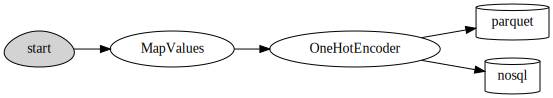

In [6]:
heart_disease_categorical = fstore.FeatureSet(
    name="heart_disease_categorical",
    entities=[fstore.Entity("patient_id")]
)

age_mapping = {'age': {'ranges': {'toddler': [0, 3], 'child': [3, 18], 'adult': [18, 65], 'elder': [65, 120]}}}

one_hot_encoder_mapping = {'age_mapped': ['toddler', 'child', 'adult', 'elder'],
                           'sex': ['male', 'female'],
                           'cp': ['typical_angina', 'atypical_angina', 'non_anginal_pain', 'asymtomatic'],
                           'exang': ['no', 'yes'],
                           'fbs': [False, True],
                           'slope': ['downsloping', 'upsloping', 'flat'],
                           'thal': ['normal', 'reversable_defect', 'fixed_defect']}

heart_disease_categorical.graph.to(MapValues(mapping=age_mapping, with_original_features=True))\
                               .to(OneHotEncoder(mapping=one_hot_encoder_mapping))

display(heart_disease_categorical.plot(rankdir='LR', with_targets=True))

resp = fstore.ingest(
    featureset=heart_disease_categorical,
    source=CSVSource(path="s3://igz-us-sales/heart/heart_disease_categorical.csv")
)

#### Create Feature Vector

In [13]:
vector = fstore.FeatureVector(
    name="heart-disease-vec",
    features=[
        "heart_disease_categorical.*",
        "heart_disease_continuous.*"
    ],
    label_feature="heart_disease_target.target",
    with_indexes=False
)
vector.save()

uri = vector.uri
uri

'store://feature-vectors/gitops-flow-v2/heart-disease-vec'

#### Use Feature Vector for Offline Training

In [14]:
fstore.get_offline_features(feature_vector=uri, target=ParquetTarget()).to_dataframe().head()

> 2023-10-16 19:36:05,639 [info] wrote target: {'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/gitops-flow-v2/FeatureStore/heart-disease-vec/parquet/vectors/heart-disease-vec-latest.parquet', 'status': 'ready', 'updated': '2023-10-16T19:36:05.639376+00:00', 'size': 34786, 'partitioned': True}


,age_mapped_toddler,age_mapped_child,age_mapped_adult,age_mapped_elder,age,sex_male,sex_female,cp_typical_angina,cp_atypical_angina,cp_non_anginal_pain,...,thal_normal,thal_reversable_defect,thal_fixed_defect,trestbps,chol,restecg,thalach,oldpeak,ca,target
0,0,0,1,0,52,1,0,1,0,0,...,1,0,0,125,212,1,168,1.0,2.0,0
1,0,0,1,0,53,1,0,1,0,0,...,1,0,0,140,203,0,155,3.1,0.0,0
2,0,0,0,1,70,1,0,1,0,0,...,1,0,0,145,174,1,125,2.6,0.0,0
3,0,0,1,0,61,1,0,1,0,0,...,1,0,0,148,203,1,161,0.0,1.0,0
4,0,0,1,0,62,0,1,1,0,0,...,0,1,0,138,294,1,106,1.9,3.0,0


#### Online Feature Vector for Real-Time Inference

In [15]:
feature_service = fstore.get_online_feature_service(uri)

In [16]:
feature_service.get(
    [
        {"patient_id" : "e443544b-8d9e-4f6c-9623-e24b6139aae0"},
        {"patient_id" : "8227d3df-16ab-4452-8ea5-99472362d982"}
    ]
)

[{'age_mapped_toddler': 0,
  'age_mapped_child': 0,
  'age_mapped_adult': 1,
  'age_mapped_elder': 0,
  'age': 52,
  'sex_male': 1,
  'sex_female': 0,
  'cp_typical_angina': 1,
  'cp_atypical_angina': 0,
  'cp_non_anginal_pain': 0,
  'cp_asymtomatic': 0,
  'exang_no': 1,
  'exang_yes': 0,
  'fbs_False': 1,
  'fbs_True': 0,
  'slope_downsloping': 1,
  'slope_upsloping': 0,
  'slope_flat': 0,
  'thal_normal': 1,
  'thal_reversable_defect': 0,
  'thal_fixed_defect': 0,
  'trestbps': 125,
  'chol': 212,
  'restecg': 1,
  'thalach': 168,
  'oldpeak': 1.0,
  'ca': 2.0},
 {'age_mapped_toddler': 0,
  'age_mapped_child': 0,
  'age_mapped_adult': 1,
  'age_mapped_elder': 0,
  'age': 53,
  'sex_male': 1,
  'sex_female': 0,
  'cp_typical_angina': 1,
  'cp_atypical_angina': 0,
  'cp_non_anginal_pain': 0,
  'cp_asymtomatic': 0,
  'exang_no': 0,
  'exang_yes': 1,
  'fbs_False': 0,
  'fbs_True': 1,
  'slope_downsloping': 0,
  'slope_upsloping': 1,
  'slope_flat': 0,
  'thal_normal': 1,
  'thal_reversa

### Run Training Pipeline

In [17]:
arguments = {
    "source_url" : uri,
    "label_column" : "target"
}
arguments

{'source_url': 'store://feature-vectors/gitops-flow-v2/heart-disease-vec',
 'label_column': 'target'}

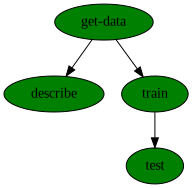

uid,start,state,name,parameters,results
...b210f6a2,Oct 16 19:49:28,completed,test,label_column=targetnew_model_path=store://artifacts/gitops-flow-v2/model:5eecc1dd-5b17-4ead-af7e-51656fff5eceexisting_model_path=Nonecomparison_metric=accuracypost_github=Trueforce_deploy=False,accuracy-new_model=1.0test-error-new_model=0.0f1-new_model=1.0precision-new_model=1.0recall-new_model=1.0
...d75678a9,Oct 16 19:48:58,completed,describe,label_column=target,
...74a9e108,Oct 16 19:48:58,completed,train,label_column=targettest_size=0.1,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0
...85c2810d,Oct 16 19:48:31,completed,get-data,,num_rows=968


In [24]:
run_id = project.run(
    name="train",
    arguments=arguments,
    dirty=True,
    watch=True
)

### Run Deployment Pipeline

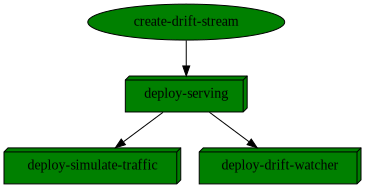

uid,start,state,name,parameters,results
...7524f484,Oct 16 19:50:26,completed,create-drift-stream,stream_path=pipelines/gitops-flow-v2/model-endpoints/log_stream,


In [25]:
run_id = project.run(
    name="deploy",
    arguments={"model_path": "store://models/gitops-flow-v2/model#0:latest"},
    dirty=True,
    watch=True
)

### Invoke Model

In [40]:
serving_fn = project.get_function("serving")
serving_fn.invoke(
    path='/v2/models/model/infer',
    body={
        "inputs" : [
            [0, 0, 1, 0, 50, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 120, 219, 1, 158, 1.6, 0.0],
            [0, 0, 1, 0, 44, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 130, 219, 0, 188, 0.0, 0.0],
            [0, 0, 0, 1, 70, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 130, 322, 0, 109, 2.4, 3.0]
        ]
    }
)

> 2023-10-17 00:33:46,244 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-gitops-flow-v2-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': 'd7615aca-d050-4fe5-ab5f-8637a0f2a4f1',
 'model_name': 'model',
 'outputs': [1, 1, 0]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [27]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = "model"

# Get test set
df = project.get_artifact("train_test_set").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
data = df.drop("target", axis=1).to_dict(orient="split")["data"]

,age_mapped_toddler,age_mapped_child,age_mapped_adult,age_mapped_elder,age,sex_male,sex_female,cp_typical_angina,cp_atypical_angina,cp_non_anginal_pain,...,thal_normal,thal_reversable_defect,thal_fixed_defect,trestbps,chol,restecg,thalach,oldpeak,ca,target
0,0,0,1,0,50,0,1,0,0,1,...,0,1,0,120,219,1,158,1.6,0.0,1
1,0,0,1,0,44,1,0,0,1,0,...,0,1,0,130,219,0,188,0.0,0.0,1
2,0,0,0,1,70,1,0,1,0,0,...,0,1,0,130,322,0,109,2.4,3.0,0
3,0,0,1,0,60,0,1,1,0,0,...,1,0,0,150,258,0,157,2.6,2.0,0
4,0,0,1,0,47,1,0,0,0,1,...,0,1,0,138,257,0,156,0.0,0.0,1


In [29]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(12_000)):
    data_point = choice(data)
    resp = serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )
    # print(resp)

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

  0%|          | 0/12000 [00:00<?, ?it/s]

## 4. Re-Training Flow via CI/CD

![](docs/gitops-flow.png)

### Simulate Drift Event

In [36]:
import json
import v3io.dataplane

In [37]:
v3io_client = v3io.dataplane.Client()

In [38]:
drift_event = {'endpoint_id': '340c863d748d4bf8e040281b75bc6eb04209fd23', 'drift_status': 'POSSIBLE_DRIFT', 'drift_measure': 0.87}

In [39]:
v3io_client.stream.put_records(
    container='users',
    stream_path=f"pipelines/{project.name}/model-endpoints/log_stream",
    records=[{'data': json.dumps(drift_event), 'shard_id': 0}]
)